In [ ]:
! pip install kneed
! pip install matplotlib
! pip install numpy
! pip install pandas
! pip install rdkit
! pip install scikit-learn


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from kneed import KneeLocator
from openeye import oechem
from rdkit import Chem
from rdkit import DataStructs
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import RobustScaler

def checkFormat(filePath):
    if not os.path.exists(filePath):
        print("File " + filePath + " does not exist.")
        return False
    
    # Create an input stream for reading a molecular data file
    fileStream = oechem.oemolistream()
    # Specify the OEB format for the input file
    fileStream.SetFormat(oechem.OEFormat_OEB)
    # Enable automatic decompression if the input file is gzipped
    fileStream.Setgz(True)

    if not fileStream.open(filePath):
        print("Could not open file " + filePath + ". Check the file format and permissions.")
        return False

    try:
        found = False

        # Check if the file contains at least one molecule
        for mol in fileStream.GetOEMols():
            found = True
            break

        if not found:
            print("No molecules were found in the file. The file may be incorrectly formatted.")
            return False
        else:
            return True
    except Exception as e:
        print("An error occurred while reading the file:", e)
        return False
    finally:
        fileStream.close()

def constructDataFrame(filePath):
    fileStream = oechem.oemolistream()
    fileStream.SetFormat(oechem.OEFormat_OEB)
    fileStream.Setgz(True)

    dataList = []
    
    fileStream.open(filePath)

    for mol in fileStream.GetOEMols():
        data = extractMolData(mol)
        dataList.append(data)
    
    fileStream.close()
    return pd.DataFrame(dataList)

def extractMolData(mol):
    data = {"Title": mol.GetTitle()}

    # Process Structure-Data tags
    for each in oechem.OEGetSDDataPairs(mol):
        tag = each.GetTag().strip()
        value = each.GetValue().strip()

        if tag.lower() == "mw" or tag.lower() == "smiles":
            continue
        
        data[tag] = value

    data["MW"] = oechem.OECalculateMolecularWeight(mol)
    data["SMILES"] = oechem.OEMolToSmiles(mol)

    # Extract the Chemgauss4 score
    for conf in mol.GetConfs():
        if oechem.OEHasSDData(conf, "FRED Chemgauss4 score"):
            data["FRED Chemgauss4 score"] = oechem.OEGetSDData(conf, "FRED Chemgauss4 score")
            break
    return data

def fingerprintToNumpy(fp):
    # Create an array of zeros with a length equal to the number of bits in the fingerprint
    array = np.zeros((fp.GetNumBits(),), dtype = int)
    DataStructs.ConvertToNumpyArray(fp, array)
    return array

In [2]:
filePath = "UROD_IBS_docked.oeb.gz"

if checkFormat(filePath):
    df = constructDataFrame(filePath)

In [3]:
keywords = ["title", "donor", "acceptor", "rotatable", "tpsa", "mw", "smiles", "fred chemgauss4 score"]

# Determine the type of logP
logpKeyword = None
logpType = None

for col in df.columns:
    if "clogp" in col.lower():
        logpKeyword = "clogp"
        logpType = "clogP"
        break

    if "logp" in col.lower():
        logpKeyword = "logp"
        logpType = "logP"
        break

keywords.insert(keywords.index("tpsa"), logpKeyword)

# Filter columns
filteredCols = []

for k in keywords:
    for col in df.columns:                
        if k in col.lower():
            filteredCols.append(col)      
            break

filteredDf = df[filteredCols].copy()

# Rename columns for consistency
renamedCols = ["title", "donors", "acceptors", "rotatable", logpType, "TPSA", "MW", "SMILES", "FRED Chemgauss4 score"]
renameMap = dict(zip(filteredCols, renamedCols))
filteredDf.rename(columns = renameMap, inplace = True)

# Drop rows with missing values
filteredDf = filteredDf.dropna().reset_index(drop = True)

# Ensure data types are correct
filteredDf["donors"] = filteredDf["donors"].astype(int)
filteredDf["acceptors"] = filteredDf["acceptors"].astype(int)
filteredDf["rotatable"] = filteredDf["rotatable"].astype(int)
filteredDf[logpType] = filteredDf[logpType].astype(float)
filteredDf["TPSA"] = filteredDf["TPSA"].astype(float)
filteredDf["MW"] = filteredDf["MW"].astype(float)
filteredDf["FRED Chemgauss4 score"] = filteredDf["FRED Chemgauss4 score"].astype(float)

# Convert SMILES strings to RDKit Mol objects
filteredDf["RDKit Mol"] = filteredDf["SMILES"].apply(lambda smiles: Chem.MolFromSmiles(smiles))
# Generate RDKit fingerprints from molecule objects
filteredDf["fingerprint"] = filteredDf["RDKit Mol"].apply(lambda mol: Chem.RDKFingerprint(mol))
# Convert each fingerprint to a 1D NumPy bit vector
filteredDf["fingerprint"] = filteredDf["fingerprint"].apply(lambda fp: fingerprintToNumpy(fp))

filteredDf = filteredDf.drop(columns = ["RDKit Mol"])

# Scale numerical features
scaler = RobustScaler()
numericalFeatures = ["donors", "acceptors", "rotatable", logpType, "TPSA", "MW"]
scaledFeatures = scaler.fit_transform(filteredDf[numericalFeatures])

# Stack fingerprint vectors into a 2D matrix
fingerprintMatrix = np.vstack(filteredDf["fingerprint"].values)

X = np.hstack([scaledFeatures, fingerprintMatrix])

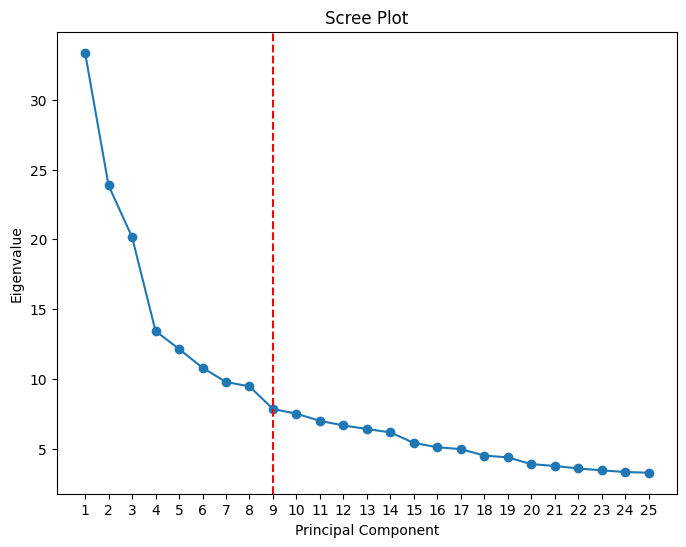

In [4]:
# Create a scree plot to determine the optimal number of components for PCA
pca = PCA().fit(X)
eigenvalues = pca.explained_variance_
kneedle = KneeLocator(range(1, 25 + 1), eigenvalues[:25], curve = "convex", direction = "decreasing")
elbow = kneedle.elbow

plt.figure(figsize = (8, 6))
plt.plot(range(1, 25 + 1), eigenvalues[:25], marker = "o")
plt.axvline(x = kneedle.elbow, color = "red", linestyle = "--")
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Eigenvalue")
plt.xticks(range(1, 25 + 1))
plt.show()

# Perform PCA to reduce dimensionality
pca = PCA(n_components = elbow, random_state = 0)
xPca = pca.fit_transform(X)

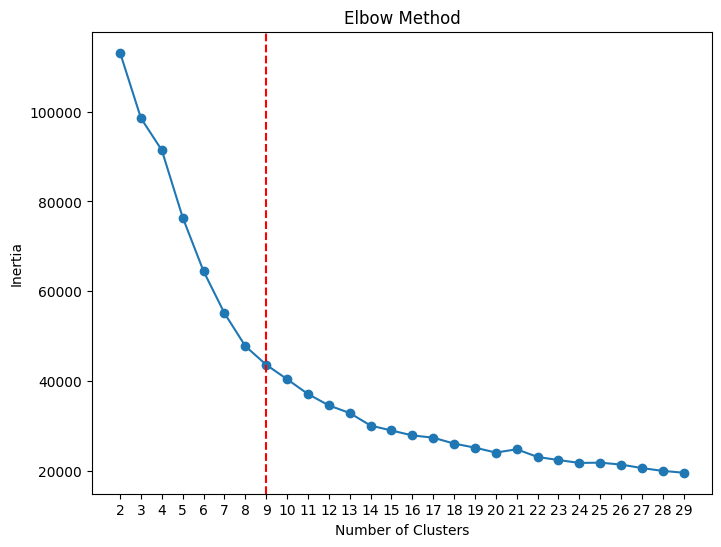

Optimal Number of Clusters: 9
Silhouette Score: 0.3465972496202368


In [5]:
# Apply KMeans clustering
kRange = range(2, 30)
inertias = []

for k in kRange:
    kmeans = KMeans(n_clusters = k, random_state = 0)
    kmeans.fit(xPca)
    inertias.append(kmeans.inertia_)

kneedle = KneeLocator(kRange, inertias, curve = "convex", direction = "decreasing")
elbow = kneedle.elbow

plt.figure(figsize = (8, 6))
plt.plot(kRange, inertias, marker = "o")
plt.axvline(x = elbow, color = "red", linestyle = "--")
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.xticks(kRange)
plt.show()

kmeans = KMeans(n_clusters = elbow, random_state = 0)
kmeans.fit(xPca)
silhouette = silhouette_score(xPca, kmeans.labels_)

print("Optimal Number of Clusters: " + str(elbow))
print("Silhouette Score: " + str(silhouette))

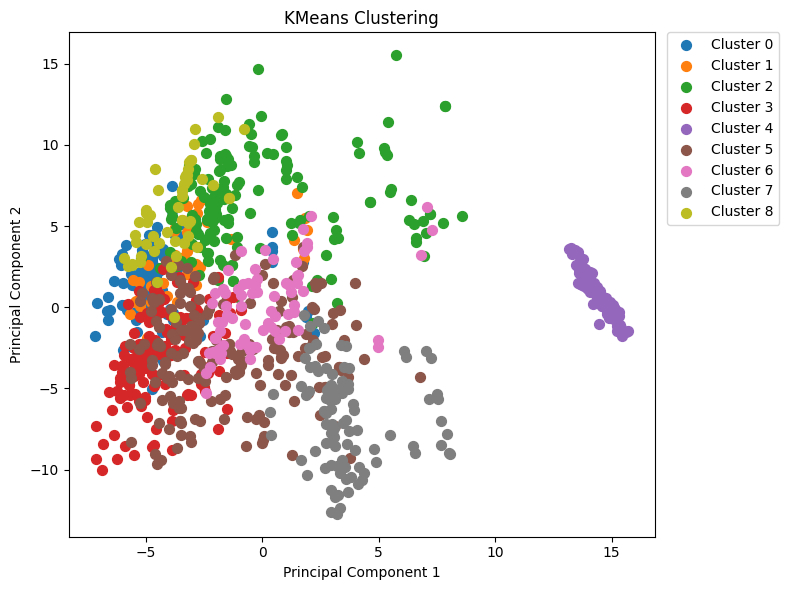

In [6]:
# Plot clustering results (KMeans)
labels = kmeans.labels_
numClusters = len(np.unique(labels))

plt.figure(figsize = (8, 6))
for clusterId in range(numClusters):
    mask = (labels == clusterId)
    plt.scatter(xPca[mask, 0], xPca[mask, 1], label = "Cluster " + str(clusterId), s = 50)

plt.title("KMeans Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(bbox_to_anchor = (1.02, 1), loc = "upper left", borderaxespad = 0)
plt.tight_layout()
plt.show()

In [7]:
# Apply DBSCAN clustering
dbscan = DBSCAN(eps = 5, min_samples = 2 * xPca.shape[1])
dbscan.fit(xPca)

numClusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
numNoise = list(dbscan.labels_).count(-1)

print("Number of Clusters: " + str(numClusters))
print("Number of Noise Points: " + str(numNoise))

if numClusters > 1:
    silhouette = silhouette_score(xPca[dbscan.labels_ != -1], dbscan.labels_[dbscan.labels_ != -1])
    print("Silhouette Score: " + str(silhouette))
else:
    print("Silhouette Score: Not applicable for a single cluster")

Number of Clusters: 9
Number of Noise Points: 360
Silhouette Score: 0.42395059155386994


In [8]:
# Tune DBSCAN hyperparameters
epsRange = np.arange(1, 8, 0.05)
minSamplesRange = range(2 * xPca.shape[1], 2 * xPca.shape[1] + 5 + 1)
noiseCap = 0.5
results = []

for eps in epsRange:
    for minSamples in minSamplesRange:
        dbscan = DBSCAN(eps = eps, min_samples = minSamples)
        dbscan.fit(xPca)
        labels = dbscan.labels_
        
        numClusters = len(set(labels)) - (1 if -1 in labels else 0)
        numNoise = list(labels).count(-1)

        if numNoise / len(labels) <= noiseCap:
            if numClusters > 1:
                silhouette = silhouette_score(xPca[labels != -1], labels[labels != -1])
                results.append((eps, minSamples, numClusters, numNoise, silhouette))

if results:
    bestResult = max(results, key = lambda r: (r[4], -r[3]))
    bestEps, bestMinSamples, bestNumClusters, bestNumNoise, bestSilhouette = bestResult

    print("Epsilon: " + str(bestEps))
    print("Min Samples: " + str(bestMinSamples))
    print("Number of Clusters: " + str(bestNumClusters))
    print("Number of Noise Points: " + str(bestNumNoise))
    print("Silhouette Score: " + str(bestSilhouette))
else:
    print("No valid results found")

Epsilon: 4.7500000000000036
Min Samples: 20
Number of Clusters: 10
Number of Noise Points: 487
Silhouette Score: 0.5411986868259999


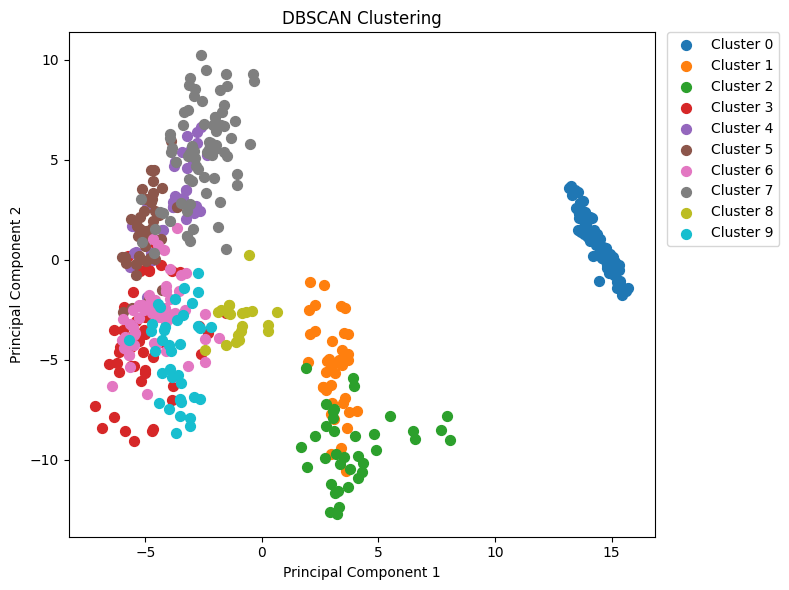

In [9]:
dbscan = DBSCAN(eps = bestEps, min_samples = bestMinSamples)
dbscan.fit(xPca)

# Plot clustering results (DBSCAN)
rawLabels = dbscan.labels_
filteredLabels = set(rawLabels) - {-1}

plt.figure(figsize = (8, 6))
for clusterId in filteredLabels:
    mask = (rawLabels == clusterId)
    plt.scatter(xPca[mask, 0], xPca[mask, 1], label = "Cluster " + str(clusterId), s = 50)

plt.title("DBSCAN Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(bbox_to_anchor = (1.02, 1), loc = "upper left", borderaxespad = 0)
plt.tight_layout()
plt.show()

In [10]:
# Sort molecules for each cluster, excluding noise points (first in the cluster being the representative)
pcaCols = ["PC" + str(i + 1) for i in range(xPca.shape[1])]
pcaDf = pd.DataFrame(xPca, columns = pcaCols)
pcaDf[numericalFeatures] = scaledFeatures
pcaDf["SMILES"] = filteredDf["SMILES"].values
pcaDf["title"] = filteredDf["title"].values
pcaDf["FRED Chemgauss4 score"] = filteredDf["FRED Chemgauss4 score"].values
pcaDf["cluster label"] = rawLabels

rows = []

for label in set(pcaDf["cluster label"]) - {-1}:
    subset = pcaDf[pcaDf["cluster label"] == label].copy()
    centre = subset[pcaCols].mean().values
    subset["distance"] = np.linalg.norm(subset[pcaCols] - centre, axis = 1)
    subset = subset.sort_values("distance").reset_index(drop = True)

    subset[numericalFeatures] = scaler.inverse_transform(subset[numericalFeatures])
    rows.append(subset[["title", *numericalFeatures, "SMILES", "FRED Chemgauss4 score", "cluster label"]])

sortedDf = pd.concat(rows, ignore_index = True)

In [11]:
# Save results to a CSV file
sortedDf.to_csv("sorted_clusters.csv", index = False)